In [ ]:
This notebook looks at the difference in happiness of registered Reub

In [41]:
from collections import defaultdict
import pandas as pd
import csv
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import seaborn

Read Original GSS Datafile

In [42]:
GSS = pd.read_excel('GSS4.xls', names = ['year','natrace','natarms','nataid',
'natfare','relig','fund','raclive','happy','satfin','finalter','finrela','coop','comprend',
'sample','oversamp','realinc','nateduc','natdrug','natcity','id_','wrkstat','hrs1','hrs2',
'evwork','wrkslf','indus10','age','sex','race','mobile16','earnrs','partyid','polviews',
'natenvir','natheal','realrinc'])

Remove Unnecessary Columns

In [43]:
GSS = GSS[['year','natrace','natarms','nataid',
'natfare','relig','fund','raclive','happy','satfin','finalter','finrela','coop','comprend',
'sample','oversamp','realinc','nateduc','natdrug','natcity','id_','wrkstat','wrkslf','indus10',
'age','sex','race','mobile16','earnrs','partyid','polviews',
'natenvir','natheal','realrinc']]

Remove Rows and Columns to Derive Clean Answers (Get Rid of 'Not Applicable')

In [44]:
GSS = GSS[GSS.natrace != 'Not applicable']
GSS = GSS[GSS.natarms != 'Not applicable']
GSS = GSS[GSS.nataid != 'Not applicable']
GSS = GSS.replace({'Not applicable': np.nan}).dropna()
len(GSS)

29779

Import Coding Schema from Separate CSV File

In [45]:
labels = defaultdict(list)

with open('GSSlabels_red.csv', encoding="utf-8") as f:
    reader = csv.reader(f)
    rows_f = [tuple(row) for row in reader]

for k,v,l in rows_f:
        labels[k].append((v,l))    
labels

defaultdict(list,
            {'age': [('92', '89 or older')],
             'comprend': [('2.5', 'No answer'),
              ('2.5', "Don't know"),
              ('3', 'Poor'),
              ('2', 'Fair'),
              ('1', 'Good')],
             'coop': [('2.5', 'No answer'),
              ('2.5', "Don't know"),
              ('4', 'Hostile'),
              ('3', 'Restless,impatient'),
              ('2', 'Cooperative'),
              ('1', 'Friendly,interested'),
              ('0', 'Not applicable')],
             'earnrs': [('8', 'Eight or more')],
             'evwork': [('1.5', 'No answer'),
              ('1.5', "Don't know"),
              ('2', 'No'),
              ('1', 'Yes'),
              ('0', 'Not applicable')],
             'finalter': [('1.5', 'No answer'),
              ('1.5', "Don't know"),
              ('3', 'Stayed same'),
              ('2', 'Worse'),
              ('1', 'Better'),
              ('0', 'Not applicable')],
             'finrela': [('2.5', 'No an

Apply Numerical Values to Pandas Dataframe Based on Coding Schema

In [46]:
dictionaries={}
for label in labels:
    dictionaries[label]={k:v for (v, k) in labels[label]}
dictionaries

{'age': {'89 or older': '92'},
 'comprend': {"Don't know": '2.5',
  'Fair': '2',
  'Good': '1',
  'No answer': '2.5',
  'Poor': '3'},
 'coop': {'Cooperative': '2',
  "Don't know": '2.5',
  'Friendly,interested': '1',
  'Hostile': '4',
  'No answer': '2.5',
  'Not applicable': '0',
  'Restless,impatient': '3'},
 'earnrs': {'Eight or more': '8'},
 'evwork': {"Don't know": '1.5',
  'No': '2',
  'No answer': '1.5',
  'Not applicable': '0',
  'Yes': '1'},
 'finalter': {'Better': '1',
  "Don't know": '1.5',
  'No answer': '1.5',
  'Not applicable': '0',
  'Stayed same': '3',
  'Worse': '2'},
 'finrela': {'Above average': '4',
  'Average': '3',
  'Below average': '2',
  "Don't know": '2.5',
  'Far above average': '5',
  'Far below average': '1',
  'No answer': '2.5',
  'Not applicable': '0'},
 'fund': {"Don't know": '1.5',
  'Fundamentalist': '1',
  'Liberal': '3',
  'Moderate': '2',
  'Na-excluded': '1.5',
  'Not applicable': '0'},
 'happy': {"Don't know": '1.5',
  'No answer': '1.5',
  'Not

In [47]:
GSS2=GSS.copy()
for i in GSS2.columns:
    if i in dictionaries:
        GSS2[i]=GSS2[i].replace(dictionaries[i])

Find out if a Republican or Democrat was in power during survey year. This will be an added feature

In [48]:
labels_pip = {}

with open('pip2.csv', encoding="utf-8") as f:
    reader = csv.reader(f)
    rows_f = [tuple(row) for row in reader]

for k,v in rows_f:
        labels_pip[k] = v  

labels_pip.pop('\ufeffyear', None)

'Republican?'

In [49]:
GSS2['pip'] = GSS2['year'].apply(lambda s: labels_pip[str(s)])

In [50]:
GSS2 = GSS2.dropna()
GSS2.columns

Index(['year', 'natrace', 'natarms', 'nataid', 'natfare', 'relig', 'fund',
       'raclive', 'happy', 'satfin', 'finalter', 'finrela', 'coop', 'comprend',
       'sample', 'oversamp', 'realinc', 'nateduc', 'natdrug', 'natcity', 'id_',
       'wrkstat', 'wrkslf', 'indus10', 'age', 'sex', 'race', 'mobile16',
       'earnrs', 'partyid', 'polviews', 'natenvir', 'natheal', 'realrinc',
       'pip'],
      dtype='object')

Get Dummies for Categorical Variables Which Cannot be Numbered on Ordinal Scale

In [51]:
GSS3 = pd.get_dummies(GSS2, drop_first = True,columns=['wrkstat','relig','sex','race'])

Further clean up to get rid of ambiguous answers

In [52]:
GSS3 = GSS3[GSS.age != 'No answer']
GSS3 = GSS3[GSS.age != "Don't know"]
GSS3 = GSS3[GSS.earnrs != "No answer"]

/Users/jitsen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/jitsen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Remove 'Ambivalent'(1.5) Label

In [53]:
GSS3 = GSS3[GSS3['happy'] != str(1.5)]

Upsample Minority Labels on Train Set

In [54]:
rand_forest2 = RandomForestClassifier()
GSS_train2, GSS_test2 = train_test_split(GSS3, test_size=0.3)
GSS_train_u = GSS_train2[GSS_train2['happy']=='3']
GSS_train_m = GSS_train2[GSS_train2['happy']=='2']
GSS_train_v = GSS_train2[GSS_train2['happy']=='1']

GSS_train2['happy'].value_counts()

2    11478
1     6629
3     2398
Name: happy, dtype: int64

By How Much Do We Need to Upsample?

In [55]:
11478-6629,11478-2398

(4849, 9080)

In [56]:
GSS_train_u_s = resample(GSS_train_u, 
                                 replace=True,  
                                 n_samples=9080)    # to match majority class
GSS_train_v_s = resample(GSS_train_v, 
                                 replace=True,     
                                 n_samples=4849)
# Combine majority class with upsampled minority class
GSS_upsampled = pd.concat([GSS_train2, GSS_train_u_s, GSS_train_v_s])

GSS_upsampled['happy'].value_counts()

3    11478
1    11478
2    11478
Name: happy, dtype: int64

In [57]:
columns = ['year', 'natrace', 'natarms', 'nataid', 'natfare', 'fund', 'raclive',
       'satfin', 'finalter', 'finrela', 'coop', 'comprend', 'sample',
       'oversamp', 'realinc', 'nateduc', 'natdrug', 'natcity', 'id_', 'wrkslf',
       'indus10', 'age', 'mobile16', 'earnrs', 'partyid', 'polviews',
       'natenvir', 'natheal', 'realrinc', 'pip', 'wrkstat_No answer',
       'wrkstat_Other', 'wrkstat_Retired', 'wrkstat_School',
       'wrkstat_Temp not working', 'wrkstat_Unempl, laid off',
       'wrkstat_Working fulltime', 'wrkstat_Working parttime',
       'relig_Catholic', 'relig_Christian', "relig_Don't know",
       'relig_Hinduism', 'relig_Inter-nondenominational', 'relig_Jewish',
       'relig_Moslem/islam', 'relig_Native american', 'relig_No answer',
       'relig_None', 'relig_Orthodox-christian', 'relig_Other',
       'relig_Other eastern', 'relig_Protestant', 'sex_Male', 'race_Other',
       'race_White']

X_train_up = GSS_upsampled[columns]

y_train_up = GSS_upsampled['happy']

X_test_up = GSS_test2[columns]

y_test_up = GSS_test2['happy']

len(X_train_up), len(y_train_up), len(X_test_up)

(34434, 34434, 8788)

Run Model Again

In [26]:
def train_fit(X_train,y_train,X_test,y_test):
    rand_forest = RandomForestClassifier(n_estimators=100, min_samples_split=2)
    rand_forest.fit(X_train, y_train)
    y_pred_train = rand_forest.predict(X_train)
    y_pred_test = rand_forest.predict(X_test)
    print('test',metrics.accuracy_score(y_test,y_pred_test), 'train', metrics.accuracy_score(y_train, y_pred_train),classification_report(y_test, y_pred_test))
    
train_fit(X_train_up,y_train_up,X_test_up,y_test_up)

test 0.567933545744 train 1.0              precision    recall  f1-score   support

          1       0.49      0.34      0.40      2765
          2       0.60      0.79      0.68      4963
          3       0.44      0.11      0.18      1060

avg / total       0.54      0.57      0.53      8788



Run a grid search to optimize trees and splits

In [27]:
def train_fit(X_train,y_train,X_test,y_test,e,s):
    rand_forest = RandomForestClassifier(n_estimators=e, min_samples_split=s)
    rand_forest.fit(X_train, y_train)
    y_pred_train = rand_forest.predict(X_train)
    y_pred_test = rand_forest.predict(X_test)
    return 'est=%s'%e, 'split=%s' %s,'test', metrics.accuracy_score(y_test,y_pred_test), 'train', metrics.accuracy_score(y_train, y_pred_train)

y_list = []
for e in range(10,101,10):
    for s in range(2,6,1):
        y_list.append(train_fit(X_train_up, y_train_up, X_test_up,y_test_up,e,s))

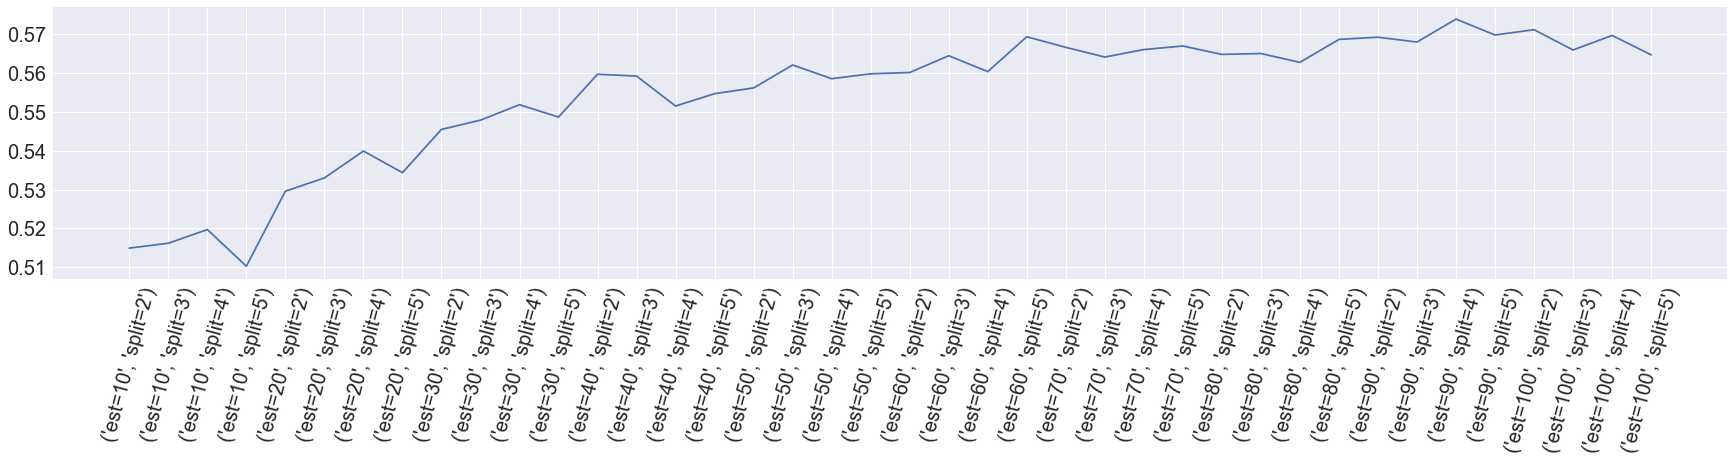

In [28]:
plt.figure(figsize = (30,5))
plt.plot([x for x in range(0,40)], [float(x[3]) for x in y_list]);
plt.xticks([x for x in range(0,40)],[x[0:2] for x in y_list], rotation = 75, fontsize = 20);
plt.yticks(fontsize = 20)
plt.show();

Try classification using Logistic Regression

In [29]:
pd.set_option('display.precision', 6)

X_train_log = X_train_up
X_train_log = X_train_log.astype('float64')
scaler = MinMaxScaler(feature_range=(0, 1))
sc1 = scaler.fit(X_train_log.astype('float64'))
X_train_log = pd.DataFrame(sc1.transform(X_train_log), columns = X_train_log.columns)

X_test_log = X_test_up
X_test_log = X_test_log.astype('float64')
scaler = MinMaxScaler(feature_range=(0, 1))
sc2 = scaler.fit(X_test_log.astype('float64'))
X_test_log = pd.DataFrame(sc2.transform(X_test_log), columns = X_test_log.columns)

In [30]:
def train_fit(X_train_log, X_test_log, y_train_up, y_test_up,c):
    Lr = LogisticRegression(penalty = 'l1', dual=False, tol=0.0001, C=c, fit_intercept=True, intercept_scaling=1)
    Lr.fit(X_train_up, y_train_up)
    Lr_test_pred = Lr.predict(X_test_log)
    Lr_train_pred = Lr.predict(X_train_log)
    print(accuracy_score(y_test_up,Lr_test_pred),accuracy_score(y_train_up, Lr_train_pred),classification_report(y_test_up,Lr_test_pred))
    

train_fit(X_train_log, X_test_log, y_train_up, y_test_up,16)

0.35593991807 0.408896641954              precision    recall  f1-score   support

          1       0.34      0.95      0.50      2765
          2       0.70      0.05      0.09      4963
          3       0.34      0.25      0.29      1060

avg / total       0.55      0.36      0.24      8788



Plot proportion of Democrats who are 'Very Happy', Happy' and 'Unhappy', and do the same for Republicans

In [31]:
GSS_year = {k: v for k, v in GSS3.groupby('year')}
democrat_dict = {}
republican_dict = {}
for k,v in GSS_year.items():
    d = v[v['partyid'] == '1']
    r = v[v['partyid'] == '6']
    democrat_dict[k] = d['happy'].value_counts()/len(d['happy'])
    republican_dict[k]= r['happy'].value_counts()/len(r['happy'])

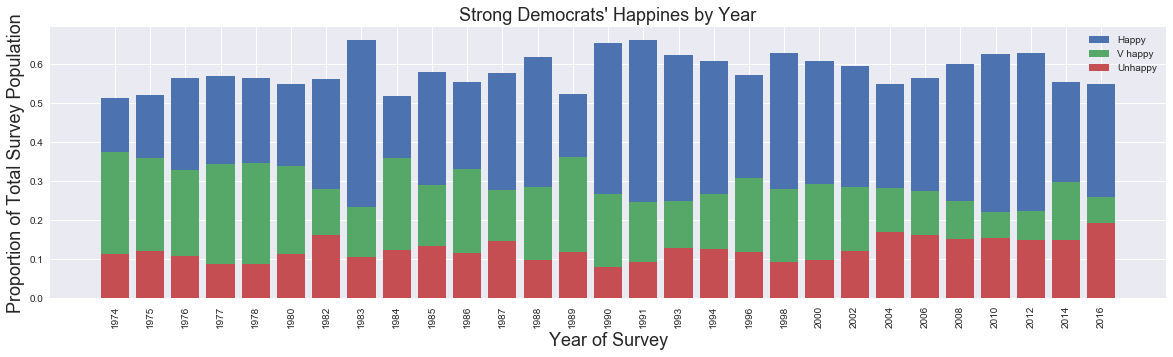

In [32]:
x = np.arange(len(democrat_dict))
y = [x[0] for x in democrat_dict.values()]
y1 = [x[1] for x in democrat_dict.values()]
y2 = [x[2] for x in democrat_dict.values()]
plt.figure(figsize = (20,5));
plt.bar(x, y,  label = 'Happy')
plt.bar(x, y1, label = 'V happy')
plt.bar(x, y2, label = 'Unhappy')
plt.xlabel('Year of Survey',fontsize = 18);
plt.ylabel('Proportion of Total Survey Population',fontsize = 18);
plt.title("Strong Democrats' Happines by Year",fontsize = 18);
plt.legend();
plt.xticks(x, democrat_dict.keys(), rotation='vertical')
plt.show();

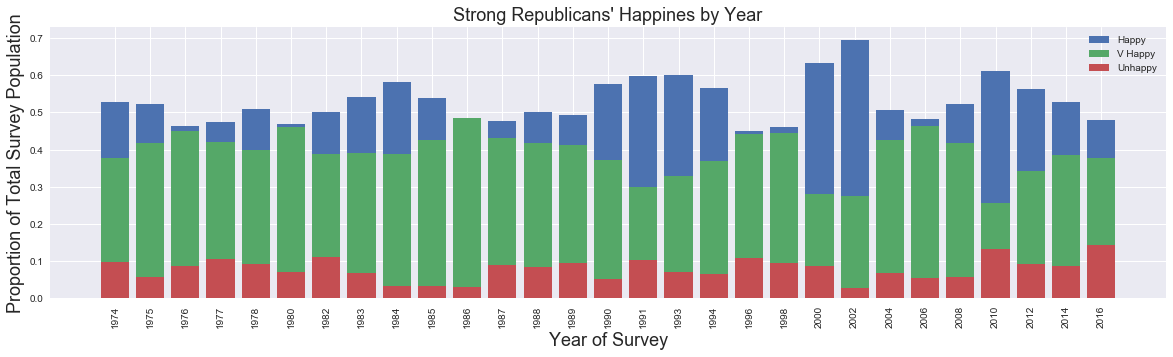

In [33]:
x = np.arange(len(democrat_dict))
y = [x[0] for x in republican_dict.values()]
y1 = [x[1] for x in republican_dict.values()]
y2 = [x[2] for x in republican_dict.values()]
plt.figure(figsize = (20,5));
plt.bar(x, y, label = 'Happy');
plt.bar(x, y1, label = 'V Happy');
plt.bar(x, y2, label = 'Unhappy');
plt.xlabel('Year of Survey',fontsize = 18);
plt.ylabel('Proportion of Total Survey Population',fontsize = 18);
plt.title("Strong Republicans' Happines by Year",fontsize = 18);
plt.legend();
plt.xticks(x, democrat_dict.keys(), rotation='vertical');
plt.show();

Plot proportion of high income earners who are 'Very Happy','Happy' and 'Unhappy' and do the same for low income
earners

In [34]:
GSS_year = {k: v for k, v in GSS3.groupby('year')}
high_dict = {}
low_dict = {}
for k,v in GSS_year.items():
    h = v[v['realrinc'] > 40000]
    l = v[v['realrinc'] < 40000]
    high_dict[k] = h['happy'].value_counts()/len(h['happy'])
    low_dict[k]= l['happy'].value_counts()/len(l['happy'])

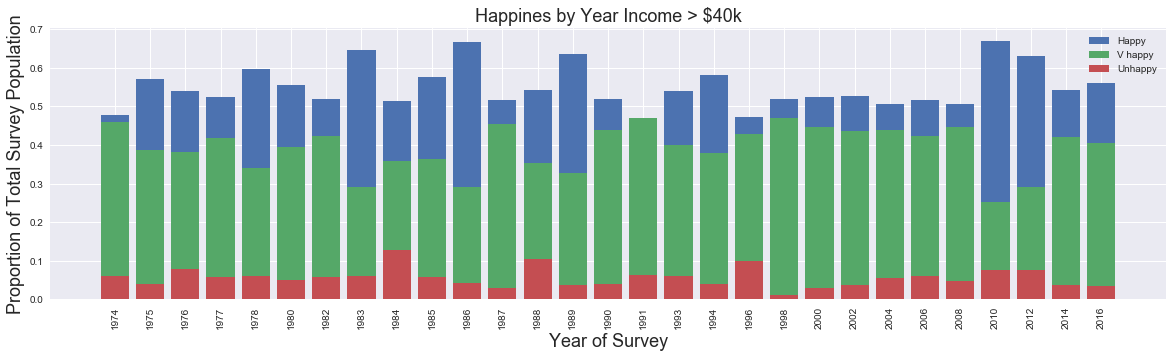

In [35]:
x = np.arange(len(high_dict))
y = [x[0] for x in high_dict.values()]
y1 = [x[1] for x in high_dict.values()]
y2 = [x[2] for x in high_dict.values()]
plt.figure(figsize = (20,5));
plt.bar(x, y,  label = 'Happy')
plt.bar(x, y1, label = 'V happy')
plt.bar(x, y2, label = 'Unhappy')
plt.xlabel('Year of Survey',fontsize = 18);
plt.ylabel('Proportion of Total Survey Population',fontsize = 18);
plt.title("Happines by Year Income > $40k",fontsize = 18);
plt.legend();
plt.xticks(x, high_dict.keys(), rotation='vertical')
plt.show();

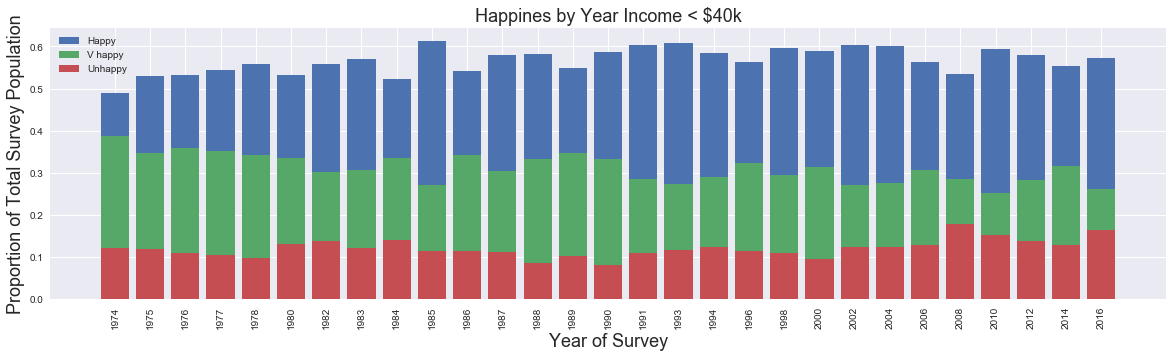

In [36]:
y = [x[0] for x in low_dict.values()]
y1 = [x[1] for x in low_dict.values()]
y2 = [x[2] for x in low_dict.values()]
plt.figure(figsize = (20,5));
plt.bar(x, y,  label = 'Happy')
plt.bar(x, y1, label = 'V happy')
plt.bar(x, y2, label = 'Unhappy')
plt.xlabel('Year of Survey',fontsize = 18);
plt.ylabel('Proportion of Total Survey Population',fontsize = 18);
plt.title("Happines by Year Income < $40k",fontsize = 18);
plt.legend();
plt.xticks(x, low_dict.keys(), rotation='vertical')
plt.show();